<a href="https://colab.research.google.com/github/Naive-Bae/notebooks/blob/main/capstone_employee_retention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip --quiet

# Improving Employee Retention

## Project objective

The goals of this project are to:

1. Analyze data collected by the HR department at a large consulting firm

2. Build a machine learning model that predicts whether or not an employee will leave the company

If we can predict employees likely to quit, it may be possible to identify factors that contribute to their leaving. Because it is time-consuming and expensive to find, interview, and hire new employees, increasing employee retention will be beneficial to the company.

## Data dictionary

The data for this project comes from [Kaggle](https://www.kaggle.com/datasets/mfaisalqureshi/hr-analytics-and-job-prediction?select=HR_comma_sep.csv).

Rows: 14,999  
Columns: 10

Feature  |Description |
-----|-----|
satisfaction_level|Employee-reported job satisfaction level [0&ndash;1]|
last_evaluation|Score of employee's last performance review [0&ndash;1]|
number_project|Number of projects employee contributes to|
average_monthly_hours|Average number of hours employee worked per month|
time_spend_company|How long the employee has been with the company (years)
Work_accident|Whether or not the employee experienced an accident while at work
left|Whether or not the employee left the company
promotion_last_5years|Whether or not the employee was promoted in the last 5 years
Department|The employee's department
salary|The employee's salary (U.S. dollars)

## Import statements

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# This lets us see all of the columns, preventing Juptyer from redacting them.
pd.set_option('display.max_columns', None)

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import plot_importance

# Metrics and helpers
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score,  confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.tree import plot_tree

# This module lets us save our models once we fit them.
import pickle

from pandas_profiling import ProfileReport

# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Read in the data

In [ ]:
url = 'https://raw.githubusercontent.com/adacert/hr/main/HR_comma_sep.csv'
df0 = pd.read_csv(url)
df0.head()

satisfaction_level  last_evaluation  number_project  average_montly_hours  \
0                0.38             0.53               2                   157   
1                0.80             0.86               5                   262   
2                0.11             0.88               7                   272   
3                0.72             0.87               5                   223   
4                0.37             0.52               2                   159   

   time_spend_company  Work_accident  left  promotion_last_5years Department  \
0                   3              0     1                      0      sales   
1                   6              0     1                      0      sales   
2                   4              0     1                      0      sales   
3                   5              0     1                      0      sales   
4                   3              0     1                      0      sales   

   salary  
0     low  
1  medium  
2  medium  
3     low  
4     low

# Exploratory data analysis (EDA)

In [ ]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [ ]:
df0.describe()

satisfaction_level  last_evaluation  number_project  \
count        14999.000000     14999.000000    14999.000000   
mean             0.612834         0.716102        3.803054   
std              0.248631         0.171169        1.232592   
min              0.090000         0.360000        2.000000   
25%              0.440000         0.560000        3.000000   
50%              0.640000         0.720000        4.000000   
75%              0.820000         0.870000        5.000000   
max              1.000000         1.000000        7.000000   

       average_montly_hours  time_spend_company  Work_accident          left  \
count          14999.000000        14999.000000   14999.000000  14999.000000   
mean             201.050337            3.498233       0.144610      0.238083   
std               49.943099            1.460136       0.351719      0.425924   
min               96.000000            2.000000       0.000000      0.000000   
25%              156.000000            3.000000       0.000000      0.000000   
50%              200.000000            3.000000       0.000000      0.000000   
75%              245.000000            4.000000       0.000000      0.000000   
max              310.000000           10.000000       1.000000      1.000000   

       promotion_last_5years  
count           14999.000000  
mean                0.021268  
std                 0.144281  
min                 0.000000  
25%                 0.000000  
50%                 0.000000  
75%                 0.000000  
max                 1.000000

Let's standardize the column names so they're all in `snake_case` and correct the `average_monthly_hours` spelling. We can also rename `time_spend_company` to `tenure`, which is more manageable.

### Fix column names

In [ ]:
# Correct 'Work_accident', 'Department', and 'average_monthly_hours' col names
df0 = df0.rename(columns={'Work_accident': 'work_accident',
                          'average_montly_hours': 'average_monthly_hours',
                          'time_spend_company': 'tenure',
                          'Department': 'department'
                          }
                 )

Now let's check for duplicate rows.

### Check duplicates

In [ ]:
# Check for duplicates (not including first occurences)
df0.duplicated().sum()

3008

3,008 rows are duplicates. That's 20% of our data! Let's inspect some of them.

In [ ]:
df0[df0.duplicated()].head()

satisfaction_level  last_evaluation  number_project  \
396                 0.46             0.57               2   
866                 0.41             0.46               2   
1317                0.37             0.51               2   
1368                0.41             0.52               2   
1461                0.42             0.53               2   

      average_monthly_hours  tenure  work_accident  left  \
396                     139       3              0     1   
866                     128       3              0     1   
1317                    127       3              0     1   
1368                    132       3              0     1   
1461                    142       3              0     1   

      promotion_last_5years  department  salary  
396                       0       sales     low  
866                       0  accounting     low  
1317                      0       sales  medium  
1368                      0       RandD     low  
1461                      0       sales     low

The above output is the first five occurences of rows that are duplicated farther down in the dataframe. How likely is it that these are legitimate entries? In other words, how plausible is it that two people would have the same exact values for each column?

We could perform a likelihood analysis by essentially applying Bayes' theorem and multiplying the probabilities of finding each value in each column, but this doesn't seem necessary. With several continuous variables across 10 columns, it feels very unlikely that these observations are legitimate. Let's drop them.

In [ ]:
df1 = df0.drop_duplicates(keep='first')

Now we'll begin examining the variables. We'll start by creating a boxplot showing `average_monthly_hours` distributions for `number_project`, comparing the distributions of those who stayed vs. those who left.

We'll also plot a histogram. Box plots are very useful to tell us about the distributions within the data, but they can be deceiving if we don't know how big the sample sizes are that they represent.

### Monthly hours by number of projects

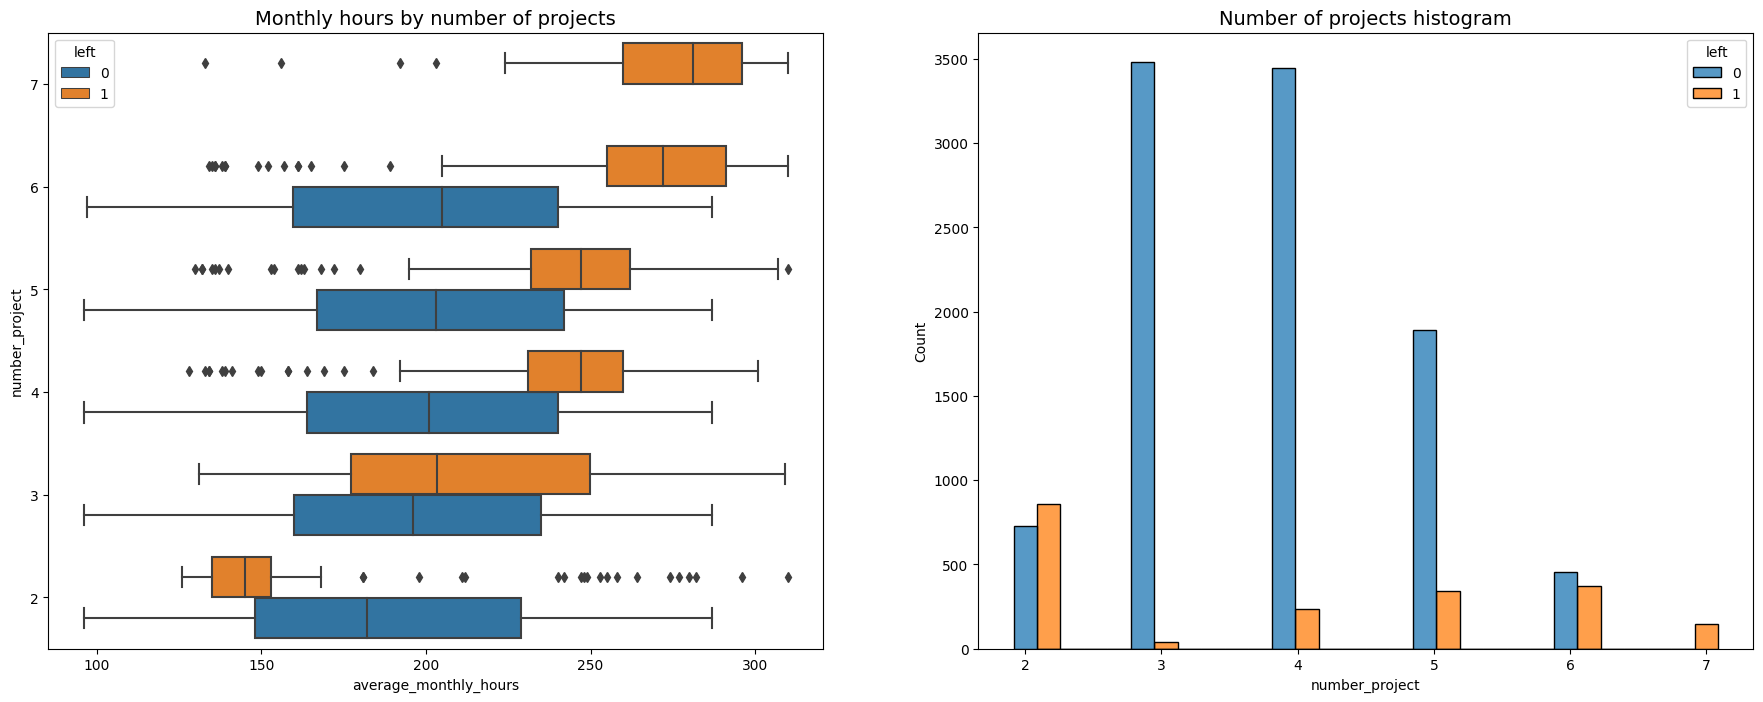

In [ ]:
# Set figure and axes
fig, ax = plt.subplots(1, 2, figsize = (22,8))

# Boxplot
sns.boxplot(data=df1, x='average_monthly_hours', y='number_project', hue='left', orient="h", ax=ax[0])
ax[0].invert_yaxis()
ax[0].set_title('Monthly hours by number of projects', fontsize='14')

# Histogram
tenure_stay = df1[df1['left']==0]['number_project']
tenure_left = df1[df1['left']==1]['number_project']
sns.histplot(data=df1, x='number_project', hue='left', multiple='dodge', shrink=2, ax=ax[1])
ax[1].set_title('Number of projects histogram', fontsize='14')

plt.show();

It might be natural that people who work on more projects would also work longer hours. This appears to be the case here, with the mean hours of each group (stayed and left) increasing with number of projects worked. However, a few things stand out from this plot.

1. There are two categories of people who left the company: (a) those who worked considerably less than their peers with the same number of projects, and (b) those who worked much more. Of those in group A, it's possible that they were fired. It's also possible that this group includes people who had already given their notice and were assigned fewer hours because they were already on their way out the door. For those in group B, it's reasonable to infer that they probably quit. These people are like the people in a group project at school who do all the work for the others.

2. Everybody with seven projects left the company, and the interquartile ranges of this group and those who left with six projects was ~255&ndash;295 hours/week&mdash;much more than any other group.

3. The optimal number of projects for people to work on seems to be 3&ndash;4. The ratio of left/stayed is very small for these cohorts.

4. If we assume a work week of 40 hours and two weeks' vacation per year, then the average number of working hours per month of people working Monday&ndash;Friday `= 50 weeks * 40 hours per week / 12 months = 166.67 hours per month`. This means that, aside from the people who worked on two projects, every group&mdash;even those didn't leave the company&mdash;worked considerably more hours than this. It seems that people here are overworked.

Let's confirm that everybody with seven projects left.

In [ ]:
# Get value counts of stayed/left for people with 7 projects
df0[df0['number_project']==7]['left'].value_counts()

1    256
Name: left, dtype: int64

They did. Now, we'll examine the average monthly hours vs. satisfaction levels.

### Monthly hours by satisfaction score

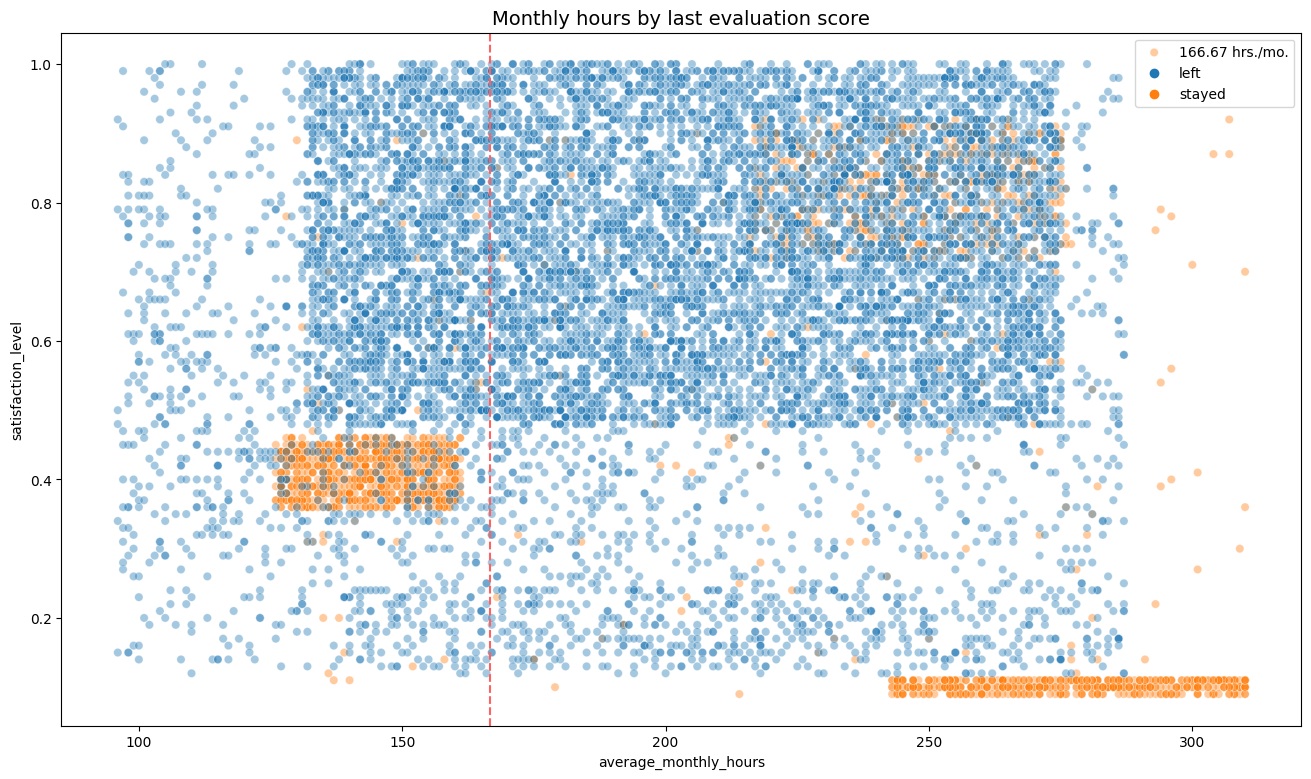

In [ ]:
plt.figure(figsize=(16, 9))
sns.scatterplot(data=df1, x='average_monthly_hours', y='satisfaction_level', hue='left', alpha=0.4)
plt.axvline(x=166.67, color='#ff6361', label='166.67 hrs./mo.', ls='--')
plt.legend(labels=['166.67 hrs./mo.', 'left', 'stayed'])
plt.title('Monthly hours by last evaluation score', fontsize='14');

This graph tells us that there was a sizeable group of people who worked ~240&ndash;315 hours per month. 315 hours per month is over 75 hours per week for a whole year! It's no wonder their satisfaction levels were close to zero.

Then there is another group of people who left, and they had more normal working hours. Even so, their satisfaction was only around 0.4. It's difficult to speculate about why they might have left. It's possible they felt pressured to work more, considering so many of their peers worked more.

Finally, there is a group who worked ~210&ndash;280 hours per month and they had satisfaction levels ranging ~0.7&ndash;0.9.

Note the strange shape of the distributions here. This is indicative of data manipulation or synthetic data.

### Satisfaction by tenure

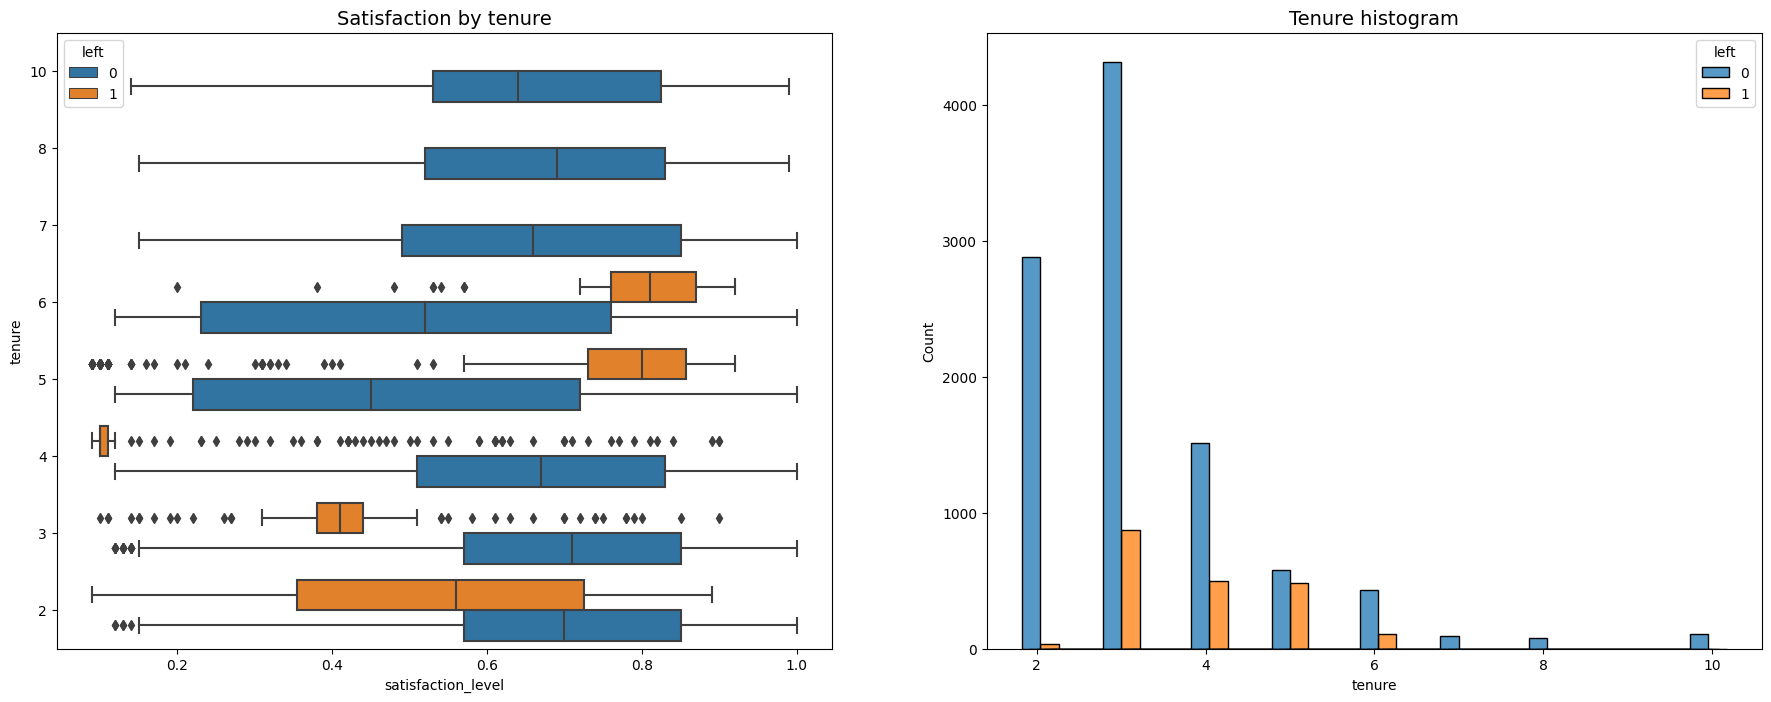

In [ ]:
# Set figure and axes
fig, ax = plt.subplots(1, 2, figsize = (22,8))

# Boxplot
sns.boxplot(data=df1, x='satisfaction_level', y='tenure', hue='left', orient="h", ax=ax[0])
ax[0].invert_yaxis()
ax[0].set_title('Satisfaction by tenure', fontsize='14')

# Histogram
tenure_stay = df1[df1['left']==0]['tenure']
tenure_left = df1[df1['left']==1]['tenure']
sns.histplot(data=df1, x='tenure', hue='left', multiple='dodge', shrink=5, ax=ax[1])
ax[1].set_title('Tenure histogram', fontsize='14')

plt.show();

There's a lot happening here. First, notice that those who left fall into two general categories: dissatisfied people with shorter tenures, and very satisfied people with medium-length tenures. Notice also that four-year employees who left seem to have an unusually low satisfaction level. It's worth investigating changes to company policy that might have affected people specifically at the four-year mark, if possible.

The longest-tenured employees didn't leave. Their satisfaction levels were in alignment with those of newer employees who stayed. The histogram tells us that there are relatively few of the longer-tenured people though. It's possible that they're the higher-ranking, higher-paid employees. We'll investigate this soon.

First, let's calculate the mean and median satisfaction scores of people who left and those who didn't.

In [ ]:
# Calculate mean and median satisfaction scores of people who left/stayed
df1.groupby(['left'])['satisfaction_level'].agg([np.mean,np.median])

mean  median
left                  
0     0.667365    0.69
1     0.440271    0.41

As expected, the satisfaction scores of people who left are lower than those of people who stayed. Interestingly, the mean satisfaction score of long-tenured employees appears to be slightly below the company-wide satisfaction score of employees who stayed.

Now let's examine salary levels for different tenures.

### Salary by tenure

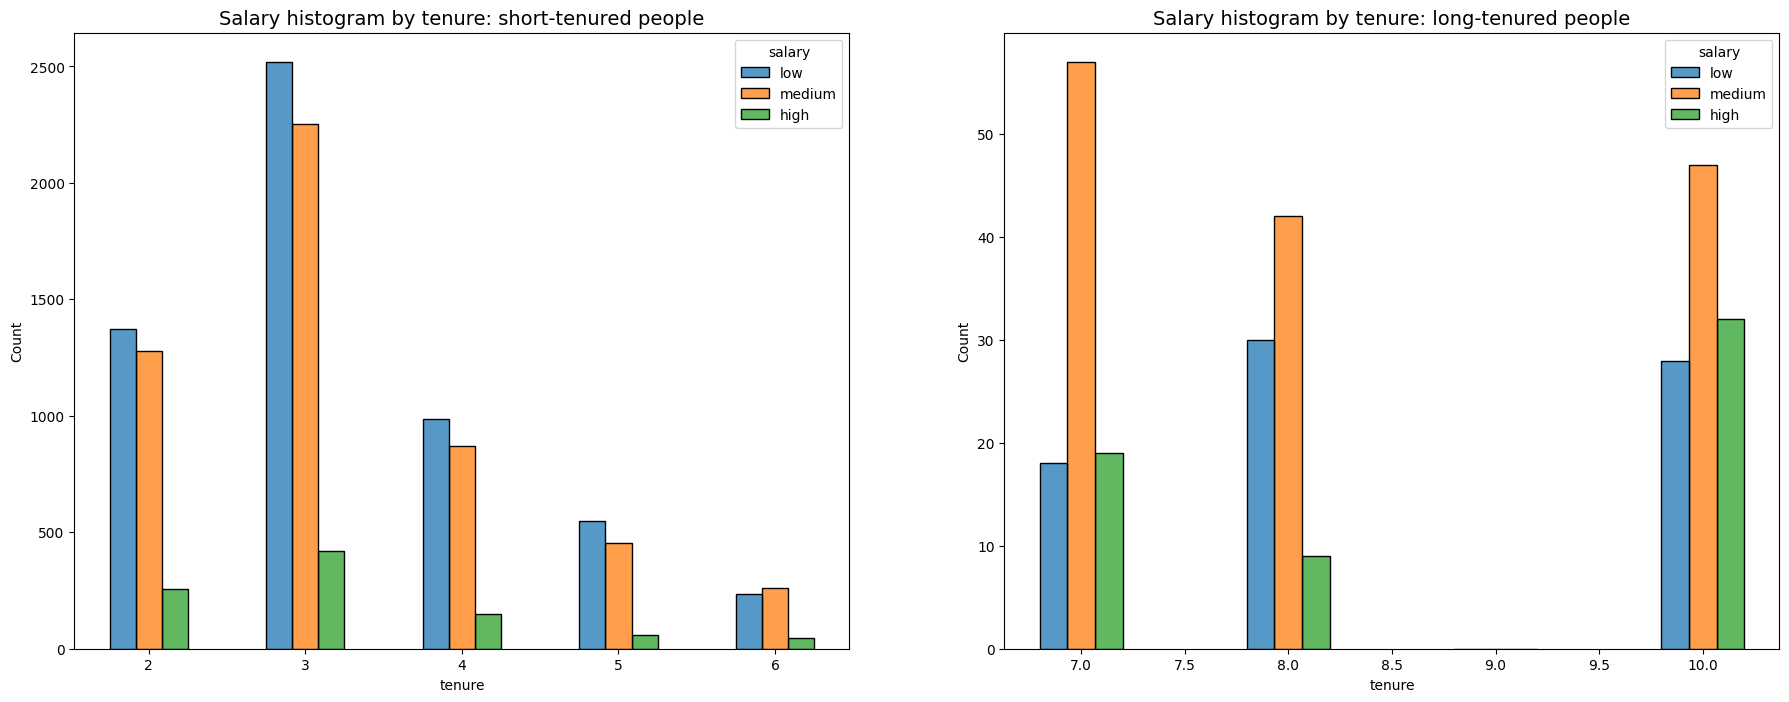

In [ ]:
# Set figure and axes
fig, ax = plt.subplots(1, 2, figsize = (22,8))

# Define short-tenured people
tenure_short = df1[df1['tenure'] < 7]

# Define long-tenured people
tenure_long = df1[df1['tenure'] > 6]

# Plot short-tenured hist
sns.histplot(data=tenure_short, x='tenure', hue='salary', discrete=1,
             hue_order=['low', 'medium', 'high'], multiple='dodge', shrink=.5, ax=ax[0])
ax[0].set_title('Salary histogram by tenure: short-tenured people', fontsize='14')

# Plot long-tenured hist
sns.histplot(data=tenure_long, x='tenure', hue='salary', discrete=1,
             hue_order=['low', 'medium', 'high'], multiple='dodge', shrink=.4, ax=ax[1])
ax[1].set_title('Salary histogram by tenure: long-tenured people', fontsize='14');

Interesting. The longer-tenured people were not disproportionately comprised of higher-paid employees, at least not majorly.

Let's explore whether there's a correlation between working long hours and receiving high evaluation scores. We'll do this by plotting a comparison of these variables.

### Monthly hours by evaluation score

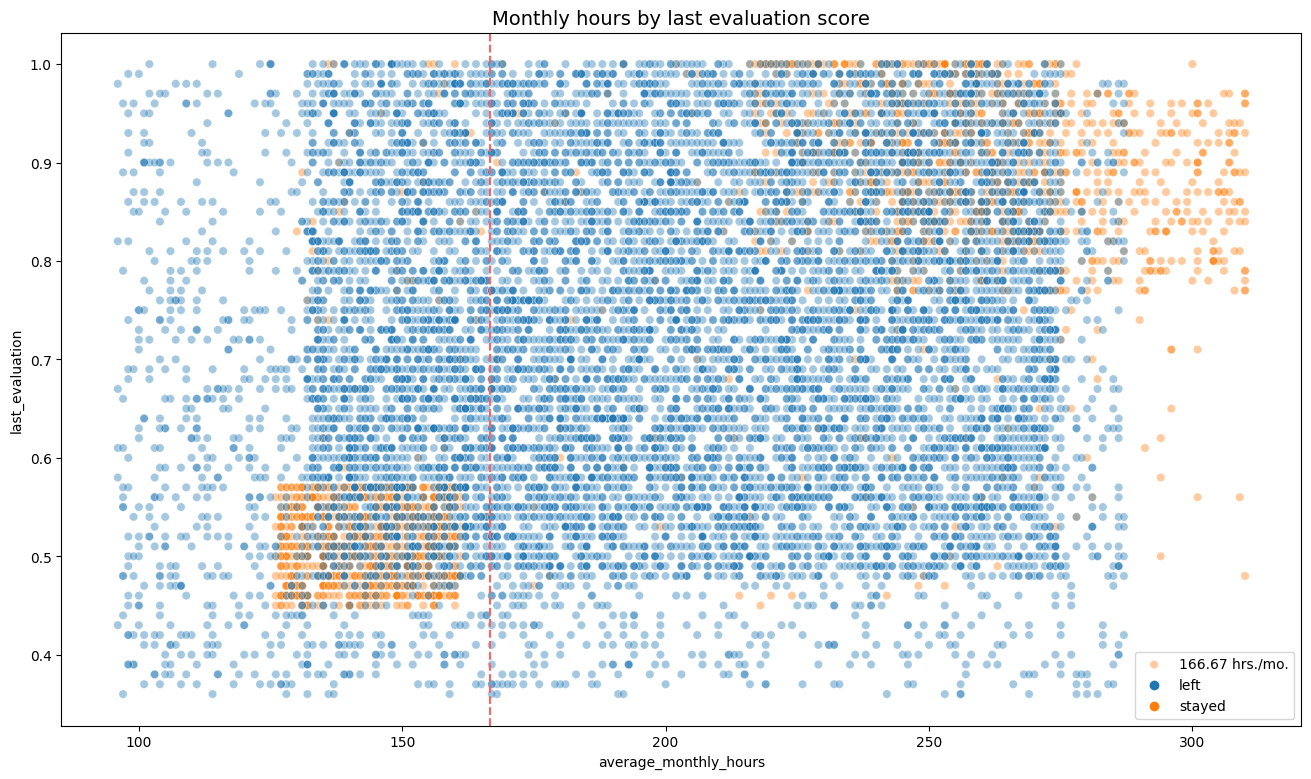

In [ ]:
plt.figure(figsize=(16, 9))
sns.scatterplot(data=df1, x='average_monthly_hours', y='last_evaluation', hue='left', alpha=0.4)
plt.axvline(x=166.67, color='#ff6361', label='166.67 hrs./mo.', ls='--')
plt.legend(labels=['166.67 hrs./mo.', 'left', 'stayed'])
plt.title('Monthly hours by last evaluation score', fontsize='14');

There seem to be two groups of people who left here: overworked people who performed very well, and people who worked slightly under the nominal monthly average of 166.67 hours with lower evaluation scores. There is a clear correlation between hours worked and evaluation score. There's not a high percentage of people in the upper left quadrant of this plot. But working long hours doesn't guarantee a good evaluation score.

We should also note that most of the people in this company work well over 167 hours per month!

Let's examine now whether people who worked very long hours were promoted in the last five years.

### Monthly hours by promotion in the last 5 years

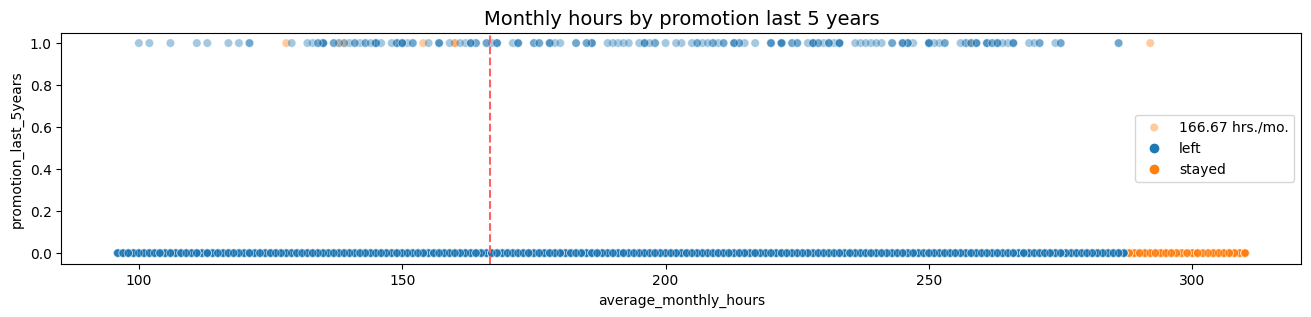

In [ ]:
plt.figure(figsize=(16, 3))
sns.scatterplot(data=df1, x='average_monthly_hours', y='promotion_last_5years', hue='left', alpha=0.4)
plt.axvline(x=166.67, color='#ff6361', ls='--')
plt.legend(labels=['166.67 hrs./mo.', 'left', 'stayed'])
plt.title('Monthly hours by promotion last 5 years', fontsize='14');

Very few people who were promoted in the last five years left, and basically none of the hardest-working people were promoted. And all of these hard workers left.

Lastly, let's inspect how the people who left are distributed across departments.

### Departments

In [ ]:
df1.department.value_counts()

sales          3239
technical      2244
support        1821
IT              976
RandD           694
product_mng     686
marketing       673
accounting      621
hr              601
management      436
Name: department, dtype: int64

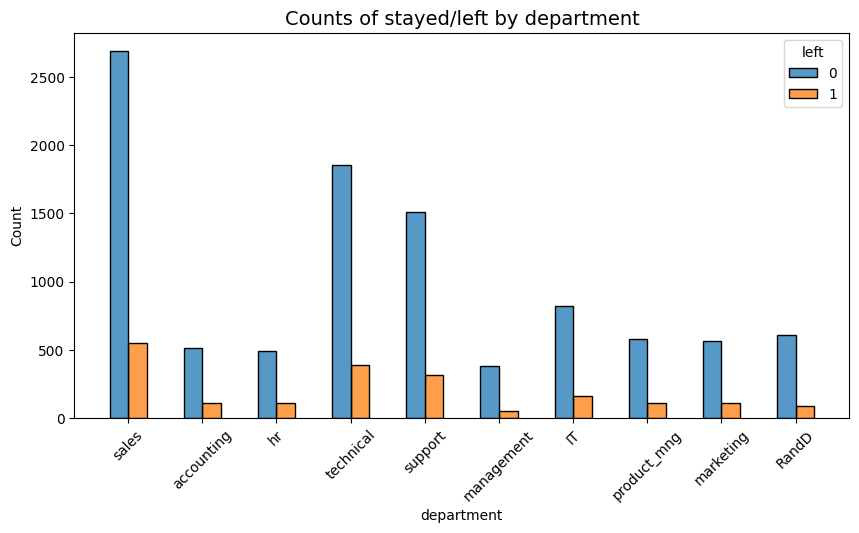

In [ ]:
# Compare departments of those who left to those who didn't
plt.figure(figsize=(10,5))
sns.histplot(data=df1, x='department', hue='left', discrete=1,
             hue_order=[0, 1], multiple='dodge', shrink=.5)
plt.xticks(rotation=45)
plt.title('Counts of stayed/left by department', fontsize=14);


There doesn't seem to be any department that differs significantly in its proportion of employees who left to those who stayed. Lastly, let's check for strong correlations between our variables.

### Correlation heatmap

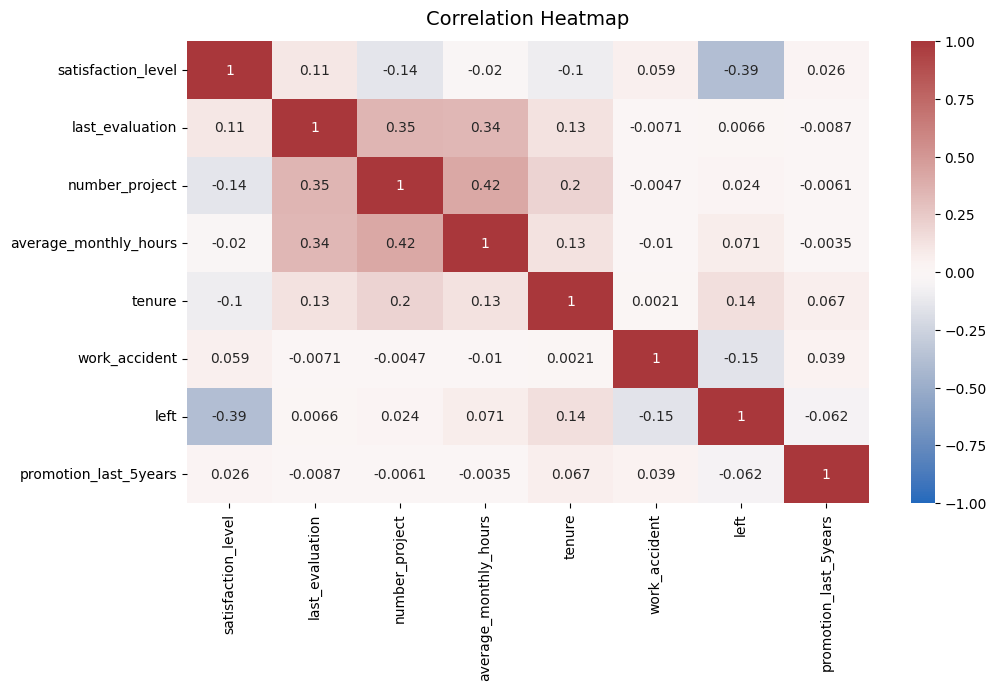

In [ ]:
# Plot a correlation heatmap
plt.figure(figsize=(11, 6))
heatmap = sns.heatmap(df0.corr(numeric_only=True), vmin=-1, vmax=1, annot=True, cmap=sns.color_palette("vlag", as_cmap=True))
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':14}, pad=12);

The correlation heatmap confirms what we discovered above: number of projects, monthly hours, and evaluation scores all have some positive correlation with each other, and people leaving is negatively correlated with their satisfaction level.

### Insights

The problem with people leaving seems to result from poor management. We know that leaving is tied to longer working hours, many projects, and generally lower satisfaction levels. It's especially ungratifying when you work long, hard hours, and don't receive promotions or good evaluation scores, which we know is common from our analysis. There's a sizeable group of people at this company who are probably just burned out. However, if an employee lasts for longer than six years, they tend not to leave.

In [ ]:
profile = ProfileReport(df0, title='HR satisfaction', html={'style':{'full_width':True}})
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# Subset employees who left the company
left = df0[df0['left']==1]

In [ ]:
profile_left = ProfileReport(left, title='Employees who left', html={'style':{'full_width':True}})
profile_left.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Modeling

## Modeling objective

We'll begin by building a model that predicts whether a person will leave the company. If we can predict people who will leave, it may be possible to take measures to intervene before they do. This could save the company money and time training new employees, and also increase job satisfaction of employees who are at risk of quitting.

## Model design and target variable

We'll use the `left` column as the target variable. This is a binary value that indicates whether or not a customer left the company. For each employee, our model should predict whether they should have a 0 or a 1 in the `left` column.

This is a classification task, because we are trying to predict on a binary class. Therefore, we will use classifier models.

For this project, we'll use `DecisionTreeClassifier`, `RandomForestClassifier`, and `XGBClassifier`.

## Modeling strategy

We'll use all available features for this initial modeling.

We'll also take a more rigorous approach to model validation and selection. We'll split into training, validation, and test sets. We'll tune the model using cross-validation on the training dataset, then perform model selection using the validation set. Finally, we'll test the champion model's performance on the test holdout set.

![](https://raw.githubusercontent.com/adacert/churn/main/optimal_model_flow.svg)

## Evaluation metrics

First, let's check the class balance of the data.

In [ ]:
print(df1.left.value_counts())
percent_left = (len(df1[df1['left']==1]) / len(df1)) * 100
print('\n')
print('Percent that left: ', round(percent_left, 2))

0    10000
1     1991
Name: left, dtype: int64


Percent that left:  16.6


We have a slightly imbalanced dataset, but we can use it without modification. It's also worth restating that we're using the dataset that has had duplicate values removed.

We're going to focus on F1 score and also area under the ROC curve (AUC). The AUC can be interpreted as the probability that a randomly selected actual responder will be assigned a higher response probability by the model than a randomly selected actual non-responder.

We'll also capture precision, recall, and accuracy for purposes of analysis and understanding the behavior of our models.

## Variable encoding

Before we split the data, let's encode the non-numeric variables. There are two: `department` and `salary`.

`department` is a categorical variable, which means we can dummy it for modeling.

`salary` is categorical too, but it's ordinal. There's a hierarchy to the categories, so it's better not to dummy this column, but rather to convert the levels to numbers, 0&ndash;2.

Begin with `salary`.

In [ ]:
df2 = df1.copy()
df2['salary'] = (
    df2['salary'].astype('category')
    .cat.set_categories(['low', 'medium', 'high'])
    .cat.codes
)
df2.head()

satisfaction_level  last_evaluation  number_project  average_monthly_hours  \
0                0.38             0.53               2                    157   
1                0.80             0.86               5                    262   
2                0.11             0.88               7                    272   
3                0.72             0.87               5                    223   
4                0.37             0.52               2                    159   

   tenure  work_accident  left  promotion_last_5years department  salary  
0       3              0     1                      0      sales       0  
1       6              0     1                      0      sales       1  
2       4              0     1                      0      sales       1  
3       5              0     1                      0      sales       0  
4       3              0     1                      0      sales       0

Now, dummy the `department` variable.

In [ ]:
df2 = pd.get_dummies(df2, drop_first=True)
df2.head()

satisfaction_level  last_evaluation  number_project  average_monthly_hours  \
0                0.38             0.53               2                    157   
1                0.80             0.86               5                    262   
2                0.11             0.88               7                    272   
3                0.72             0.87               5                    223   
4                0.37             0.52               2                    159   

   tenure  work_accident  left  promotion_last_5years  salary  \
0       3              0     1                      0       0   
1       6              0     1                      0       1   
2       4              0     1                      0       1   
3       5              0     1                      0       0   
4       3              0     1                      0       0   

   department_RandD  department_accounting  department_hr  \
0                 0                      0              0   
1                 0                      0              0   
2                 0                      0              0   
3                 0                      0              0   
4                 0                      0              0   

   department_management  department_marketing  department_product_mng  \
0                      0                     0                       0   
1                      0                     0                       0   
2                      0                     0                       0   
3                      0                     0                       0   
4                      0                     0                       0   

   department_sales  department_support  department_technical  
0                 1                   0                     0  
1                 1                   0                     0  
2                 1                   0                     0  
3                 1                   0                     0  
4                 1                   0                     0

## Split the data

Remember, we're splitting the data three ways: train / validate / test. We'll use a 60/20/20 split. To achieve this split, we'll first split into 80/20 train / test sets, then split the train set 75/25 to get the validation set, which is equivalent to 60% and 20% of the full dataset. We stratify each time.

In [ ]:
# Split into X & y
X = df2.drop('left', axis=1)
y = df2['left']

# Create test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Create train & validate data
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train, random_state=42)

## Round 1

The first round of modeling will use all the features to predict employees who left.

### Decision tree

In [ ]:
# Instantiate model
tree = DecisionTreeClassifier(random_state=42)

# Assign a dictionary of hyperparameters to search over
cv_params = {'max_depth':[4, 6, 8, None],
             'min_samples_leaf': [2, 5, 1],
             'min_samples_split': [2, 4, 6]
             }

# Assign a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}

# Instantiate GridSearch
tree1 = GridSearchCV(tree, cv_params, scoring=scoring, cv=4, refit='roc_auc')

In [ ]:
%%time
tree1.fit(X_tr, y_tr)

CPU times: user 3.21 s, sys: 2.44 ms, total: 3.21 s
Wall time: 3.22 s


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [4, 6, 8, None],
                         'min_samples_leaf': [2, 5, 1],
                         'min_samples_split': [2, 4, 6]},
             refit='roc_auc',
             scoring={'accuracy', 'precision', 'roc_auc', 'f1', 'recall'})

In [ ]:
# Check best AUC score on CV
tree1.best_score_

0.9693104174789806

In [ ]:
# Check best params
tree1.best_params_

{'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 2}

Wow! This is a very strong score. This model can predict employees who will leave very well.

Let's write a function that will help us extract all the scores from the grid search.

In [ ]:
def make_results(model_name:str, model_object, metric:str):
  '''
  Arguments:
    model_name (string): what you want the model to be called in the output table
    model_object: a fit GridSearchCV object
    metric (string): precision, recall, f1, accuracy, or auc

  Returns a pandas df with the F1, recall, precision, accuracy, and auc scores
  for the model with the best mean 'metric' score across all validation folds.
  '''

  # Create dictionary that maps input metric to actual metric name in GridSearchCV
  metric_dict = {'auc': 'mean_test_roc_auc',
                 'precision': 'mean_test_precision',
                 'recall': 'mean_test_recall',
                 'f1': 'mean_test_f1',
                 'accuracy': 'mean_test_accuracy',
                 }

  # Get all the results from the CV and put them in a df
  cv_results = pd.DataFrame(model_object.cv_results_)

  # Isolate the row of the df with the max(metric) score
  best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

  # Extract Accuracy, precision, recall, and f1 score from that row
  auc = best_estimator_results.mean_test_roc_auc
  f1 = best_estimator_results.mean_test_f1
  recall = best_estimator_results.mean_test_recall
  precision = best_estimator_results.mean_test_precision
  accuracy = best_estimator_results.mean_test_accuracy

  # Create table of results
  table = pd.DataFrame()
  table = pd.DataFrame({'model': [model_name],
                        'precision': [precision],
                        'recall': [recall],
                        'F1': [f1],
                        'accuracy': [accuracy],
                        'auc': [auc]
                        },
                       )

  return table

In [ ]:
# Get all CV scores
tree1_cv_results = make_results('decision tree cv', tree1, 'auc')
tree1_cv_results

model  precision    recall        F1  accuracy
0  decision tree cv   0.907672  0.912126  0.909726  0.969974

These are all great scores. Let's try a random forest model now.

### Random forest

In [ ]:
# Instantiate model
rf = RandomForestClassifier(random_state=0)

# Assign a dictionary of hyperparameters to search over
cv_params = {'max_depth': [3,5, None],
             'max_features': [1.0],
             'max_samples': [0.7, 1.0],
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,3,4],
             'n_estimators': [300, 500],
             }

# Assign a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}

# Instantiate GridSearch
rf1 = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='roc_auc')

In [ ]:
# %%time
# rf1.fit(X_tr, y_tr) # --> Wall time: 22min 41s

CPU times: user 21min 51s, sys: 4.35 s, total: 21min 56s
Wall time: 22min 41s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [3, 5, None], 'max_features': [1.0],
                         'max_samples': [0.7, 1.0],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [300, 500]},
             refit='roc_auc',
             scoring={'roc_auc', 'recall', 'precision', 'accuracy', 'f1'})

In [ ]:
import pickle

# Define a path to the folder where you want to save the model
path = '/content/drive/MyDrive/Colab Notebooks/'

Define functions to pickle the model and read in the model.

In [ ]:
def write_pickle(path, model_object, save_as:str):
  '''
  In:
    path:         path of folder where you want to save the pickle
    model_object: a model you want to pickle
    save_as:      filename for how you want to save the model

  Out: A call to pickle the model in the folder indicated
  '''

  with open(path + save_as + '.pickle', 'wb') as to_write:
    pickle.dump(model_object, to_write)

In [ ]:
# Write pickle
#write_pickle(path, rf1, 'hr_rf1')

In [ ]:
def read_pickle(path, saved_model_name:str):
  '''
 In:
    path:             path to folder where you want to read from
    saved_model_name: filename of pickled model you want to read in

  Out:
    model: the pickled model
  '''
  with open(path + saved_model_name + '.pickle', 'rb') as to_read:
    model = pickle.load(to_read)

    return model

In [ ]:
# Read in pickle
rf1 = read_pickle(path, 'hr_rf1')

In [ ]:
# Check best AUC score on CV
rf1.best_score_

0.9792886525344346

In [ ]:
# Check best params
rf1.best_params_

{'max_depth': 5,
 'max_features': 1.0,
 'max_samples': 1.0,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 500}

In [ ]:
# Get all CV scores
rf1_cv_results = make_results('random forest cv', rf1, 'auc')
print(tree1_cv_results)
print(rf1_cv_results)

              Model       AUC  Precision    Recall        F1  Accuracy
0  decision tree cv  0.969539   0.907826  0.913798  0.910647  0.970252
              Model       AUC  Precision    Recall        F1  Accuracy
0  random forest cv  0.979289   0.955356  0.905431  0.929391  0.977203


These scores are even better than the decision tree scores, with the exception of recall, which is 0.008 lower&mdash;a negligible amount.

Let's try XGBoost.

### XGBoost

In [ ]:
# Instantiate model
xgb = XGBClassifier(objective='binary:logistic',
                    sampling_method='gradient_based', # using with a GPU, otherwise omit
                    tree_method='gpu_hist',           # using with a GPU, otherwise omit
                    subsample=0.75,
                    random_state=0)

# Assign a dictionary of hyperparameters to search over
cv_params = {'max_depth': [3,5,7],
             'min_child_weight': [4,5,6],
             'learning_rate': [0.08, 0.1],
             'n_estimators': [250, 350, 450]
             }

# Assign a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}

# Instantiate GridSearch
xgb1 = GridSearchCV(xgb, cv_params, scoring=scoring, cv=4, refit='roc_auc')

In [ ]:
# %%time
# xgb1.fit(X_tr, y_tr) #--> Wall time: 3min 45s

CPU times: user 3min 22s, sys: 6.79 s, total: 3min 29s
Wall time: 3min 45s


GridSearchCV(cv=4,
             estimator=XGBClassifier(sampling_method='gradient_based',
                                     subsample=0.75, tree_method='gpu_hist'),
             param_grid={'learning_rate': [0.08, 0.1], 'max_depth': [3, 5, 7],
                         'min_child_weight': [4, 5, 6],
                         'n_estimators': [250, 350, 450]},
             refit='roc_auc',
             scoring={'roc_auc', 'recall', 'precision', 'accuracy', 'f1'})

In [ ]:
# # Write pickle
# write_pickle(path, xgb1, 'hr_xgb1')

In [ ]:
# Read in pickle
xgb1 = read_pickle(path, 'hr_xgb1')

In [ ]:
# Check best AUC score on CV
xgb1.best_score_

0.9818119364660451

In [ ]:
# Check best params
xgb1.best_params_

{'learning_rate': 0.08,
 'max_depth': 3,
 'min_child_weight': 4,
 'n_estimators': 250}

In [ ]:
# Get all CV scores
xgb1_cv_results = make_results('XGBoost cv', xgb1, 'auc')
all_cv_results1 = [tree1_cv_results, rf1_cv_results, xgb1_cv_results]
all_cv_results1 = pd.concat(all_cv_results1).sort_values(by='AUC', ascending=False)
all_cv_results1

Model       AUC  Precision    Recall        F1  Accuracy
0        XGBoost cv  0.981812   0.962139  0.909609  0.934888  0.979009
0  random forest cv  0.979289   0.955356  0.905431  0.929391  0.977203
0  decision tree cv  0.969539   0.907826  0.913798  0.910647  0.970252

XGBoost is the best performer of all. Now let's evaluate these models on the validation data to select a champion.

### Validation scores

First, we'll define a function that let's us get all the scores from the model's predictions.

In [ ]:
def get_test_scores(model_name:str, model, X_test_data, y_test_data):
  '''
  Generate a table of test scores.

  In:
    model_name (string):  How you want your model to be named in the output table
    model:                A fit GridSearchCV object
    X_test_data:          numpy array of X_test data
    y_test_data:          numpy array of y_test data

  Out: pandas df of precision, recall, f1, accuracy, and AUC scores for your model
  '''

  preds = model.best_estimator_.predict(X_test_data)

  auc = round(roc_auc_score(y_test_data, preds), 3)
  accuracy = round(accuracy_score(y_test_data, preds), 3)
  precision = round(precision_score(y_test_data, preds), 3)
  recall = round(recall_score(y_test_data, preds), 3)
  f1 = round(f1_score(y_test_data, preds), 3)

  table = pd.DataFrame({'model': [model_name],
                        'AUC': [auc],
                        'precision': [precision],
                        'recall': [recall],
                        'f1': [f1],
                        'accuracy': [accuracy]
                        })

  return table

In [ ]:
tree1_val_results = get_test_scores('decision tree1 val', tree1, X_val, y_val)
rf1_val_results = get_test_scores('random forest1 val', rf1, X_val, y_val)
xgb1_val_results = get_test_scores('XGBoost1 val', xgb1, X_val, y_val)

# Concatenate validation scores into table
all_val_results1 = [tree1_val_results, rf1_val_results, xgb1_val_results]
all_val_results1 = pd.concat(all_val_results1).sort_values(by='AUC', ascending=False)
all_val_results1

model    AUC  precision  recall     f1  accuracy
0  decision tree1 val  0.957      0.925   0.930  0.927     0.976
0        XGBoost1 val  0.955      0.966   0.917  0.941     0.981
0  random forest1 val  0.954      0.948   0.917  0.932     0.978

If we select by AUC only, we would choose the decision tree as the champion model. However, we're also considering F1 score, and, to a lesser extent, the other scores. Using a holistic approach to model selection, the XGBoost model is the champion. All models are very high-performing though.

Let's use the champion model to predict on the test data now.

### Test scores

In [ ]:
# Get predictions on test data
xgb1_test_scores = get_test_scores('XGBoost1 test', xgb1, X_test, y_test)
xgb1_test_scores

model    AUC  precision  recall     f1  accuracy
0  XGBoost1 test  0.958      0.951   0.925  0.938      0.98

The test scores are very similar to the validation scores, which is good. This is a strong model. Since we used the test data only for this model, we can be more confident that our model's performance on this data is representative of how it will perform on new, unseeen data.

## Round 2

When you get scores that are as high as we just found, it's wise to be skeptical. It's not often that models perform this well with so little effort. There's a good chance that there's some data leakage occurring somewhere. Data leakage is when you use data to train your model that should not be used during training, either because it appears in the test data or because it's not data that you'd expect to have when the model is actually deployed. Training a model with leaked data is like cheating, and your model will give an unrealistic score that is not replicated in production.

In our case, it's likely that the company won't have satisfaction levels reported for all of its employees. It's also possible that the `average_monthly_hours` column is a source of some data leakage. If employees are already decided upon quitting, or have already identified by management as people to be fired, they may be working fewer hours.

Let's drop `satisfaction_level` and also create a new feature that more vaguely captures whether an employee is overworked. We'll call this new feature `overworked`. It will be a binary column.

### Feature engineering

In [ ]:
# Create new df that drops `satisfaction_level` variable
df3 = df1.copy()
df3 = df3.drop('satisfaction_level', axis=1)

In [ ]:
# Create `overworked` column. For now, it's a duplicate of monthly hours.
df3['overworked'] = df3['average_monthly_hours']

# Inspect max and min monthly hours values
print('Max hours: ', df3['overworked'].max())
print('Min hours: ', df3['overworked'].min())

Max hours:  310
Min hours:  96


We know that 166.67 is the average number of monthly hours for someone who works 50 weeks per year, 5 days per week, 8 hours per day. Let's say that someone is overworked if they work more than 175 hours per month on average.

To create our binary column, we'll reassign the series using a Boolean mask. By calling `df3['overworked'] > 175`, we're getting creating a Boolean series where all values > 175 are `True` and all values ≤ 175 are `False`. Then we use `.astype(int)` to convert all `True` to `1` and all `False` to `0`.

In [ ]:
# "Overworked" will be defined as > 175 hrs/week
df3['overworked'] = (df3['overworked'] > 175).astype(int)
df3['overworked'].head()

0    0
1    1
2    1
3    1
4    0
Name: overworked, dtype: int64

Don't forget to drop the `average_monthly_hours` column now that we're done with it.

In [ ]:
# Drop avg. monthly hours col
df3 = df3.drop('average_monthly_hours', axis=1)

### Split the data

In [ ]:
# Encode categorical variables
df4 = pd.get_dummies(df3)

# Split into X & y
X = df4.drop('left', axis=1)
y = df4['left']

# Create test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Create train & validate data
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train, random_state=42)

### Decision tree

In [ ]:
# Instantiate model
tree = DecisionTreeClassifier(random_state=42)

# Assign a dictionary of hyperparameters to search over
cv_params = {'max_depth':[4, 6, 8, None],
             'min_samples_leaf': [2, 5, 1],
             'min_samples_split': [2, 4, 6]
             }

# Assign a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}

# Instantiate GridSearch
tree2 = GridSearchCV(tree, cv_params, scoring=scoring, cv=4, refit='roc_auc')

In [ ]:
%%time
tree2.fit(X_tr, y_tr)

CPU times: user 3.11 s, sys: 24.8 ms, total: 3.13 s
Wall time: 3.12 s


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [4, 6, 8, None],
                         'min_samples_leaf': [2, 5, 1],
                         'min_samples_split': [2, 4, 6]},
             refit='roc_auc',
             scoring={'roc_auc', 'recall', 'precision', 'accuracy', 'f1'})

In [ ]:
# Check best AUC score on CV
tree2.best_score_

0.9520354720411299

In [ ]:
# Check best params
tree2.best_params_

{'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 4}

This model still performs very well, even without satisfaction levels and detailed hours worked values. Let's check its other scores.

In [ ]:
# Get all CV scores
tree2_cv_results = make_results('decision tree2 cv', tree2, 'auc')
tree2_cv_results

Model       AUC  Precision    Recall        F1  Accuracy
0  decision tree2 cv  0.952035   0.822198  0.907118  0.861729  0.951489

Some of the other scores fell significantly. That's to be expected given what we know. Still, the scores are very good.

### Random forest

In [ ]:
# Instantiate model
rf = RandomForestClassifier(random_state=0)

# Assign a dictionary of hyperparameters to search over
cv_params = {'max_depth': [3,5, None],
             'max_features': [1.0],
             'max_samples': [0.7, 1.0],
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,3,4],
             'n_estimators': [300, 500],
             }

# Assign a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}

# Instantiate GridSearch
rf2 = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='roc_auc')

In [ ]:
# %%time
# rf2.fit(X_tr, y_tr) # --> Wall time: 17min 5s

CPU times: user 16min 40s, sys: 3.91 s, total: 16min 43s
Wall time: 17min 5s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [3, 5, None], 'max_features': [1.0],
                         'max_samples': [0.7, 1.0],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [300, 500]},
             refit='roc_auc',
             scoring={'roc_auc', 'recall', 'precision', 'accuracy', 'f1'})

In [ ]:
# # Write pickle
# write_pickle(path, rf2, 'hr_rf2')

In [ ]:
# Read in pickle
rf2 = read_pickle(path, 'hr_rf2')

In [ ]:
# Check best AUC score on CV
rf2.best_score_

0.9640279684035578

In [ ]:
# Check best params
rf2.best_params_

{'max_depth': 5,
 'max_features': 1.0,
 'max_samples': 0.7,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 500}

In [ ]:
# Get all CV scores
rf2_cv_results = make_results('random forest2 cv', rf2, 'auc')
print(tree2_cv_results)
print(rf2_cv_results)

               Model       AUC  Precision    Recall        F1  Accuracy
0  decision tree2 cv  0.952035   0.822198  0.907118  0.861729  0.951489
               Model       AUC  Precision    Recall        F1  Accuracy
0  random forest2 cv  0.964028   0.870402  0.897067  0.883459  0.960661


Again, the scores dropped slightly, but the ensemble model performs better than the decision tree.

### XGBoost

In [ ]:
# Instantiate model
xgb = XGBClassifier(objective='binary:logistic',
                    sampling_method='gradient_based', # using with a GPU, otherwise omit
                    tree_method='gpu_hist',           # using with a GPU, otherwise omit
                    subsample=0.75,
                    random_state=0)

# Assign a dictionary of hyperparameters to search over
cv_params = {'max_depth': [3,5,7],
             'min_child_weight': [4,5,6],
             'learning_rate': [0.08, 0.1],
             'n_estimators': [250, 350, 450]
             }

# Assign a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}

# Instantiate GridSearch
xgb2 = GridSearchCV(xgb, cv_params, scoring=scoring, cv=4, refit='roc_auc')

In [ ]:
# %%time
# xgb2.fit(X_tr, y_tr) #--> Wall time: 3min 35s

CPU times: user 3min 30s, sys: 7.15 s, total: 3min 37s
Wall time: 3min 35s


GridSearchCV(cv=4,
             estimator=XGBClassifier(sampling_method='gradient_based',
                                     subsample=0.75, tree_method='gpu_hist'),
             param_grid={'learning_rate': [0.08, 0.1], 'max_depth': [3, 5, 7],
                         'min_child_weight': [4, 5, 6],
                         'n_estimators': [250, 350, 450]},
             refit='roc_auc',
             scoring={'roc_auc', 'recall', 'precision', 'accuracy', 'f1'})

In [ ]:
# # Write pickle
# write_pickle(path, xgb2, 'hr_xgb2')

In [ ]:
# Read in pickle
xgb2 = read_pickle(path, 'hr_xgb2')

In [ ]:
# Check best AUC score on CV
xgb2.best_score_

0.971001697636263

In [ ]:
# Check best params
xgb2.best_params_

{'learning_rate': 0.08,
 'max_depth': 3,
 'min_child_weight': 6,
 'n_estimators': 250}

In [ ]:
# Get all CV scores
xgb2_cv_results = make_results('XGBoost2 cv', xgb2, 'auc')
all_cv_results2 = [tree2_cv_results, rf2_cv_results, xgb2_cv_results]
all_cv_results2 = pd.concat(all_cv_results2).sort_values(by='AUC', ascending=False)
all_cv_results2

Model       AUC  Precision    Recall        F1  Accuracy
0        XGBoost2 cv  0.971002   0.887322  0.868617  0.877728  0.959828
0  random forest2 cv  0.964028   0.870402  0.897067  0.883459  0.960661
0  decision tree2 cv  0.952035   0.822198  0.907118  0.861729  0.951489

Again, we have some very close scores between XGBoost and random forest, and the decision tree is not far behind them. Let's check how they perform on the validation set.

### Validation scores

In [ ]:
tree2_val_results = get_test_scores('decision tree2 val', tree2, X_val, y_val)
rf2_val_results = get_test_scores('random forest2 val', rf2, X_val, y_val)
xgb2_val_results = get_test_scores('XGBoost2 val', xgb2, X_val, y_val)

# Concatenate validation scores into table
all_val_results2 = [tree2_val_results, rf2_val_results, xgb2_val_results]
all_val_results2 = pd.concat(all_val_results2).sort_values(by='AUC', ascending=False)
all_val_results2

model    AUC  precision  recall     f1  accuracy
0  random forest2 val  0.938      0.861   0.905  0.882     0.960
0        XGBoost2 val  0.929      0.893   0.879  0.886     0.962
0  decision tree2 val  0.928      0.786   0.905  0.841     0.943

Again, we have three high-performing models. In this case, it seems that random forest might be slightly better, because it has higher recall and it's important to identify as many people who will leave as possible. Either of these models make for a strong champion model.  

Let's use the random forest champion model to predict on the test data now.

### Test scores

In [ ]:
# Get predictions on test data
rf2_test_scores = get_test_scores('random forest2 test', rf2, X_test, y_test)
rf2_test_scores

model    AUC  precision  recall     f1  accuracy
0  random forest2 test  0.943      0.865   0.915  0.889     0.962

We seem to have a stable, well-performing final model. Let's check out how it predicts on the test data by plotting a confusion matrix.

### Confusion matrix

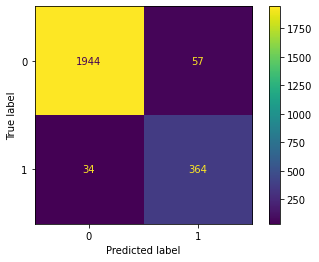

In [ ]:
# Generate array of values for confusion matrix
preds = rf2.best_estimator_.predict(X_test)
cm = confusion_matrix(y_test, preds, labels=rf2.classes_)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=rf2.classes_)
disp.plot();

The model predicts more false positives than false negatives, which means people will be identified as at risk of quitting or getting fired who are not actually at risk of doing so. This is ok though, and we still have a strong model.

Out of curiosity, let's inspect the splits of the decision tree model and also the most important features in the XGBoost model.

### Decision tree splits

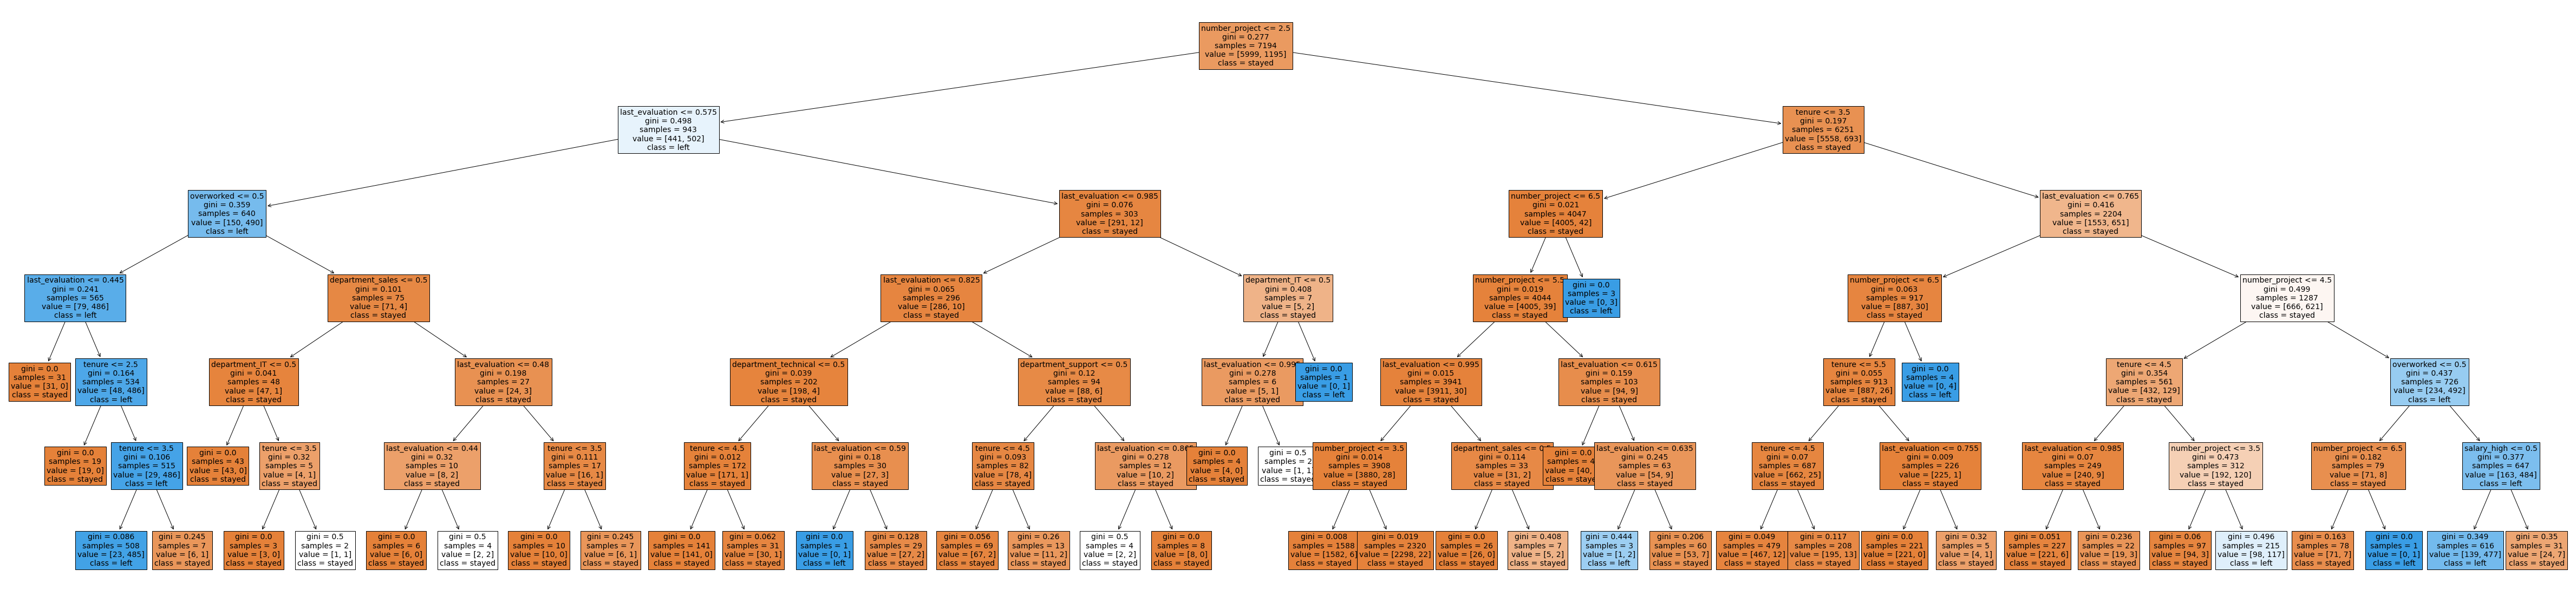

In [ ]:
# Plot the tree
plt.figure(figsize=(85,20))
plot_tree(tree2.best_estimator_, max_depth=6, fontsize=14, feature_names=X.columns,
          class_names={0:'stayed', 1:'left'}, filled=True);
plt.show()

### Decision tree feature importance

We can also get feature importance from decision trees (see the [DecisionTreeClassifier scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier.feature_importances_) for details).

In [ ]:
#tree2_importances = pd.DataFrame(tree2.best_estimator_.feature_importances_, columns=X.columns)
tree2_importances = pd.DataFrame(tree2.best_estimator_.feature_importances_, columns=['gini_importance'], index=X.columns)
tree2_importances = tree2_importances.sort_values(by='gini_importance', ascending=False)

# Only extract the features with importances > 0
tree2_importances = tree2_importances[tree2_importances['gini_importance'] != 0]
tree2_importances

gini_importance
last_evaluation              0.342390
number_project               0.326776
tenure                       0.215077
overworked                   0.100979
salary_high                  0.012360
department_IT                0.001078
department_sales             0.000823
department_technical         0.000315
department_support           0.000202

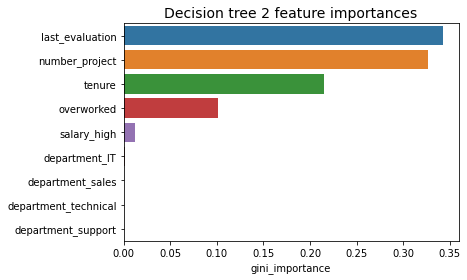

In [ ]:
sns.barplot(data=tree2_importances, x='gini_importance', y=tree2_importances.index, orient='h')
plt.title('Decision tree 2 feature importances', fontsize=14);

### XGBoost feature importance

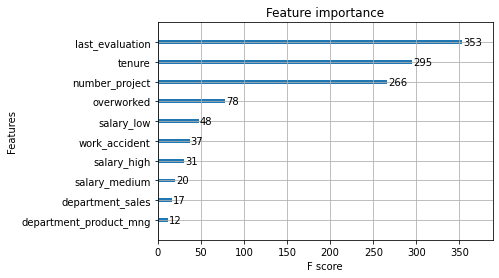

In [ ]:
plot_importance(xgb2.best_estimator_, max_num_features=10);

## Conclusion, recommendations, and next steps

The models confirm what we learned from the EDA: people at the company are overworked. To retain employees:

* Cap the number of projects people can work on.
* Consider promotions for employees who have been with the company for four years, or otherwise investigate why four-year employees are so dissatisfied.
* Either reward people for working longer hours, or don't require them to do so. Working 200+ hours per month should not be a prerequisite to get a good evaluation score.

**Next steps:**

It may be justified to still have some concern about data leakage. It could be prudent to consider how predictions change when `last_evaluation` is removed from the data. It's possible that evaluations aren't performed very frequently, in which case it would be useful to be able to predict employee retention without this feature. It's also possible that the evaluation score determines whether an employee leaves or stays, in which case it could be useful to pivot and try to predict performance score. The same could be said for satisfaction score.

For another project, try building a K-means model on this data and analyzing the clusters. This may yield valuable insight.

Finally, given the shape of some of the distributions we've seen, this data has been manipulated or synthesized entirely. It's likely that it doesn't reflect real, explicable human behavioral patterns.